In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os ; import re

In [32]:
npnts = 10001
nvib = 36
nJ = 81

#-------------------------------------------------------------------------------#
# EXTRAER AUTOFUNCIONES VIBRACIONALES
#-------------------------------------------------------------------------------#
def is_head_eigenvib(line:str) -> bool:
    """
    Detecta la linea que marca el comienzo de 
    una nueva autofunción de un nivel vibracional
    Formato: 1 0.0000 1 0 X 3Sigmam -> 
    -------> Indice Energia Estado NVib Nombre Estado
    """

    s = line.strip()
    if not s:
        return False
    
    parts = s.split()
    #Si no tiene más de 2 campos
    if len(parts) < 2:
        return False
    
    #POR SI ACASOS
    #Si el primer campo no es un entero
    if not re.fullmatch(r"[+-]?\d+", parts[0]):
        return False
    
    #Si el segundo campo no es un valor decimal
    if not re.fullmatch(r"[+-]?(\d+(\.\d*)?|\.\d+)([Ee][+-]?\d+)?", parts[1]):
        return False
    
    return True

#-------------------------------------------------------------------------------#
#Parsing Vibrational Eigenfunctions
#-------------------------------------------------------------------------------#

def parse_duo_vib_einfun(fname:str, npoints: int, nvib: int):
    """
    Parsea el archivo de autofunciones de vibración de DUO
    """
    f = open(fname, 'r')
    lines = f.readlines()

    vibmat = np.zeros((npoints,nvib))
    evect = np.zeros((nvib))
    ncurrpoint = 0 ; ncurrvib = 0
    for i,line in enumerate(lines):
        if is_head_eigenvib(line):
            ncurrpoint = 0
            ncurrvib = int(line.split()[3])
            evect[ncurrvib] = float(line.split()[1])
        elif "End of contracted basis" in line:
            break
        else:
            vibmat[ncurrpoint,ncurrvib] = float(line)
            ncurrpoint += 1

    return vibmat

#-------------------------------------------------------------------------------#
# Reading Dyson Matrix
#-------------------------------------------------------------------------------#

def dyson_mat(fname:str):
    dysvals = np.loadtxt(fname, dtype=np.float64)
    rvals = dysvals[:,0]; dys_N_C1 = dysvals[:,1] ; dys_N_C2 = dysvals[:,2]
    dysmat_N_C1 = np.zeros((dysvals.shape[0],dysvals.shape[0]))
    dysmat_N_C2 = np.zeros((dysvals.shape[0],dysvals.shape[0]))

    for i in range(dysvals.shape[0]):
            dysmat_N_C1[i][i] = dys_N_C1[i]*0.393456
            dysmat_N_C2[i][i] = dys_N_C2[i]*0.393456

    return rvals,dysmat_N_C1, dysmat_N_C2

def bra_ket(vib_ini, vib_fin, dymat):
    
    intensity = (vib_fin.T @ (dymat @ vib_ini))
    return intensity

#-------------------------------------------------------------------------------#
# Reading Energy as a function of J
#-------------------------------------------------------------------------------#

def getJvals(fname:str, nvib: int, nj: int, mult: int):
    f = open(fname, 'r')
    lines = f.readlines()

    jn = 0
    for i,line in enumerate(lines):
        if i == 0:
            Lambda_abs = abs(int(float(line.split()[5])))
            if Lambda_abs == 0:
                nOmega = mult
            else:
                nOmega = (Lambda_abs+1) * mult
            Jvals = np.zeros((nvib,nj,nOmega))

        parts = line.split()
        vibn = int(parts[4])
        jn = int(round(float(parts[0])))

        #Getting indexes for J projections
        S=(mult-1)/2
        mval = float(parts[8])
        midx = int(round(mval+S))
        
        if vibn < nvib:
            Jvals[vibn,jn,midx] = float(parts[2])
        else:
            continue

    return Jvals

#-------------------------------------------------------------------------------#
# Making the intensity matrix
#-------------------------------------------------------------------------------#

def make_int_byE(PHener,PHMener,dysmat,PHvibs,PHMvibs,maskRvals,
                OmegaPH,OmegaPHM,ZPEPH,ZPEPHM,PHsttsE,PHMsttsE,
                numvibPH:int,numvibPHM:int,
                numJPH:int,numJPHM:int):

    """
    Make the intensity matrix
    """
    Eh_to_cm = 219474.6
    dysmat = dysmat[maskRvals] ; dysmat = dysmat[:,maskRvals]
    relInt = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))
    evals = np.zeros((numvibPH,numvibPHM,numJPH,numJPHM))

    for i in range(numvibPH):
        for j in range(numvibPHM):
            PHvibsvn = PHvibs[:,i] ; PHvibsvn = PHvibsvn[mask]
            PHMvibsvn = PHMvibs[:,j] ; PHMvibsvn = PHMvibsvn[mask]
            bk_val = bra_ket(PHvibsvn,PHMvibsvn,dysmat)
            for k in range(numJPH):
                PHsumOmega = (np.average(PHener[i,k,:]+ZPEPH)/Eh_to_cm)+PHsttsE
                degJi = 2*k+1
                for l in range(numJPHM):
                    PHMsumOmega = ((np.average(PHMener[j,l,:])+ZPEPHM)/Eh_to_cm)+PHMsttsE
                    diff = abs(PHsumOmega - PHMsumOmega)
                    relInt[i,j,k,l] = degJi*diff*abs(bk_val)**2
                    evals[i,j,k,l] = diff

    return evals,relInt

#-------------------------------------------------------------------------------#
PHGSEtotal = -341.4992406252  ; ZPEPH = 1187.278444217386
PHMGSEtotal = -341.1257312537 ; ZPEPHMGS = 1177.879470966726
PHMa4Etotal = -341.0637850085 ; ZPEPHMa4Sm = 912.380170536803

pathor="/home/jorgebdelafuente/Doctorado/Photoion/DUO/PHPHM/"
PHvibs = parse_duo_vib_einfun(pathor+"PH/vibeigenvect_vib.chk", npnts, nvib)
PHMGSvibs = parse_duo_vib_einfun(pathor+"PHM_GS/vibeigenvect_vib.chk", npnts, nvib)
PHMa4Smvibs = parse_duo_vib_einfun(pathor+"PHM_a4Sm/vibeigenvect_vib.chk", npnts, nvib)

PHJener = getJvals(pathor+"PH/rovibronic_energies.dat", nvib, nJ, 3)
PHMGSJener = getJvals(pathor+"PHM_GS/rovibronic_energies.dat", nvib, nJ, 2)
PHMa4SmJener = getJvals(pathor+"PHM_a4Sm/rovibronic_energies.dat", nvib, nJ, 4)

rvals,dysmat_N_C1,dysmat_N_C2 = dyson_mat(pathor+"Dipole_moment_functions.dat")
mask = (rvals > 0.793755) & (rvals < 1.8)

evals,relInt = make_int_byE(PHJener,PHMGSJener,dysmat_N_C1,PHvibs,PHMGSvibs,mask,
                            0,0,ZPEPH,ZPEPHMGS,PHGSEtotal,PHMGSEtotal,
                            3,3,10,10)

# evals,relInt = make_int_byE(PHJener,PHMa4SmJener,dysmat_N_C2,PHvibs,PHMa4Smvibs,mask,
#                             0,0,ZPEPH,ZPEPHMa4Sm,PHGSEtotal,PHMa4Etotal,
#                             3,3,10,10)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9


(10.1, 10.3)

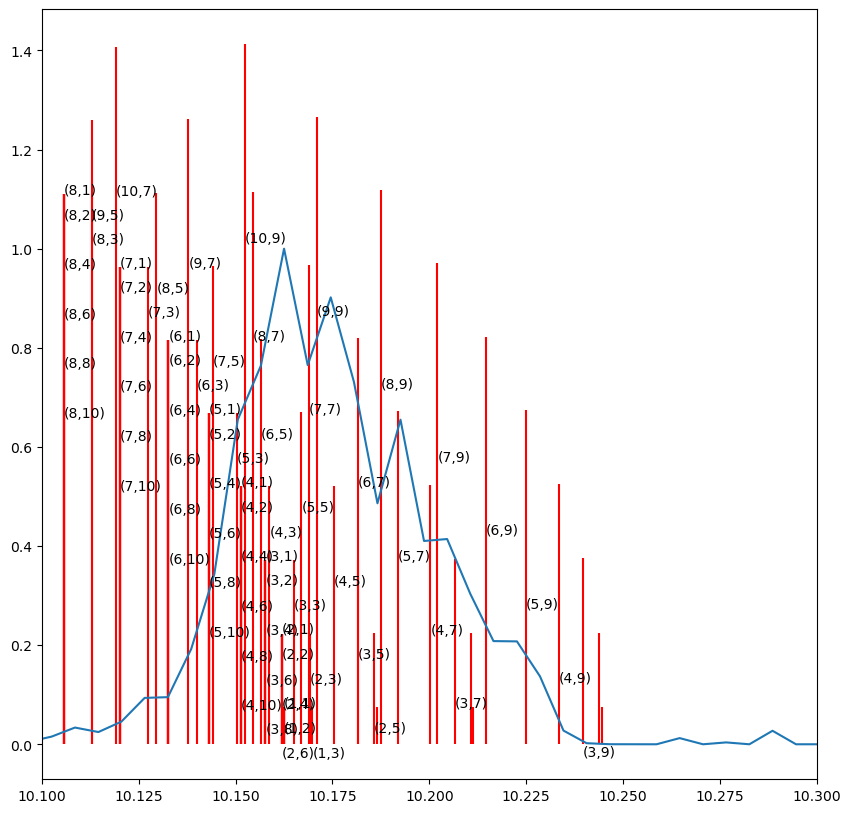

In [36]:
exp_esp = np.loadtxt("/home/jorgebdelafuente/Doctorado/Photoion/SHARC/TPES.dat",skiprows=3)
fig,ax = plt.subplots(figsize=(10,10))
maxval = np.max(exp_esp[:,2])
ax.plot(exp_esp[:,0],exp_esp[:,2]/maxval)
for i in range(10):
    less = 0
    for j in range(10):
        print(i,j)
        maxval = np.max(relInt[0,0,i,:10])
        maxval = 4
        ax.vlines(evals[0,0,i,j]*27.2114,0,relInt[0,0,i,j]/maxval,color="red",zorder=-10)
        ax.annotate(("("+str(i+1)+","+str(j+1)+")"),xy=(evals[0,0,i,j]*27.2114,relInt[0,0,i,j]/maxval-less))
        less += 0.05

ax.set_xlim(10.10,10.30)